In [1]:
#| export
verbose                       = None 
show_plots                    = True
reset_kernel                  = None 
pre_configured_case           = False
case_id                       = None
frequency_factor              = 20
frequency_factor_change_alias = True
cuda_device                   = None
check_parameters              = True

## Checking input parameters

In [2]:
#| export
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias:", frequency_factor_change_alias,
        "cuda_device:", cuda_device
)

--- Check parameters ---
verbose: None show_plots: True reset_kernel: None pre_configured_case: False case_id: None frequency_factor: 20 frequency_factor_change_alias: True cuda_device: None


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [3]:
#| export
verbose                       = 1  if verbose is None else verbose
show_plots                    = False if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 6 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 0 if  cuda_device is None else cuda_device

# Create artifact from time series dataframe
Gets a .tsf or .csv with a time serie, convert int to np.dataframe and loads it to weights and biases (W&B)

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection
### VsCode update patch
Initial notebook setup when using VSCode

In [4]:
#| export
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables
- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so (eg. `get_enc_embeddings`)
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [5]:
#| export
import dvats.config as cfg_

In [6]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [7]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code


In [8]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Path and Artiffact configurattions
This notebook gets configuration from `config\base.yaml` and `config\01-dataset_artifact.yaml`

In [9]:
#| export
base_path = Path.home()

In [10]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

artifact_name: S3
csv_config: {}
data_cols: [14]
data_fpath: ~/data/synthetic_data/synthetic_trends(II).csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1m
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: 15T
start_date: 2022-03-01
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

#### Check file content (if wanted)

In [11]:
#| hide
if verbose  > 0:
    fpath=os.path.expanduser(config.data_fpath)
    print(fpath)
    try: 
        with open(fpath, 'r') as file:
            for _ in range(13):
                line = file.readline()
                print(line, end='')
        data, _, _, _, _ = convert_tsf_to_dataframe(fpath)
        print("Timestamp", data.start_timestamp)
    except Exception as e:
        print("Error while converting file. Maybe not a tsf: ", e)

/home/macu/data/synthetic_data/synthetic_trends(II).csv
Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise,Seasonal time series w/ noise and trend
2022-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.96222892706668,-20.0,-16.03777107293332,-16.03777107293332
2022-03-01 00:01:00,0.0,0.0,0.0,0.0,0.04363101609320877,0.02617919114268888,0.0523592129902436,0.12216942022614125,0.013089927854239713,0.0006233318353470939,3.3734467291348826,-19.864117320084272,-16.49067059094939,-16.48867059094939
2022-03-01 00:02:00,0.0,0.0,0.0,0.0,0.08724874175625241,0.0523538966157463,0.10471443862370106,0.24431707699569977,0.026179606495121806,0.0012466634285032065,1.2951565214427627,-19.728256653080674,-18.43310013163791,-18.42910013163791
2022-03-01 00:03:00,0.0,0.0,0.0,0.0,0.13083989060735957,0.07851963151

#### Extract data

In [12]:
#| hide
config.data_fpath

'~/data/synthetic_data/synthetic_trends(II).csv'

In [13]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')


In [14]:
#| hide
if verbose > 0:
    print(f'File loaded successfully')
    print(df.shape)
    display(df.head())

File loaded successfully
(28800, 15)


,Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise,Seasonal time series w/ noise and trend
0,2022-03-01 00:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.962229,-20.000000,-16.037771,-16.037771
1,2022-03-01 00:01:00,0.0,0.0,0.0,0.0,0.043631,0.026179,0.052359,0.122169,0.013090,0.000623,3.373447,-19.864117,-16.490671,-16.488671
2,2022-03-01 00:02:00,0.0,0.0,0.0,0.0,0.087249,0.052354,0.104714,0.244317,0.026180,0.001247,1.295157,-19.728257,-18.433100,-18.429100
3,2022-03-01 00:03:00,0.0,0.0,0.0,0.0,0.130840,0.078520,0.157062,0.366421,0.039269,0.001870,2.710434,-19.592440,-16.882006,-16.876006
4,2022-03-01 00:04:00,0.0,0.0,0.0,0.0,0.174391,0.104672,0.209397,0.488460,0.052357,0.002493,-1.970193,-19.456689,-21.426883,-21.418883


#### Set the time column (if any) as index

In [15]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise,Seasonal time series w/ noise and trend
0,2022-03-01 00:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.962229,-20.000000,-16.037771,-16.037771
1,2022-03-01 00:01:00,0.0,0.0,0.0,0.0,0.043631,0.026179,0.052359,0.122169,0.013090,0.000623,3.373447,-19.864117,-16.490671,-16.488671
2,2022-03-01 00:02:00,0.0,0.0,0.0,0.0,0.087249,0.052354,0.104714,0.244317,0.026180,0.001247,1.295157,-19.728257,-18.433100,-18.429100
3,2022-03-01 00:03:00,0.0,0.0,0.0,0.0,0.130840,0.078520,0.157062,0.366421,0.039269,0.001870,2.710434,-19.592440,-16.882006,-16.876006
4,2022-03-01 00:04:00,0.0,0.0,0.0,0.0,0.174391,0.104672,0.209397,0.488460,0.052357,0.002493,-1.970193,-19.456689,-21.426883,-21.418883


#### Set dataframe frequency

In [16]:
#| export
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

<Minute>


In [17]:
df.head()

,Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise,Seasonal time series w/ noise and trend
2022-03-01 00:00:00,2022-03-01 00:00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.962229,-20.000000,-16.037771,-16.037771
2022-03-01 00:01:00,2022-03-01 00:01:00,0.0,0.0,0.0,0.0,0.043631,0.026179,0.052359,0.122169,0.013090,0.000623,3.373447,-19.864117,-16.490671,-16.488671
2022-03-01 00:02:00,2022-03-01 00:02:00,0.0,0.0,0.0,0.0,0.087249,0.052354,0.104714,0.244317,0.026180,0.001247,1.295157,-19.728257,-18.433100,-18.429100
2022-03-01 00:03:00,2022-03-01 00:03:00,0.0,0.0,0.0,0.0,0.130840,0.078520,0.157062,0.366421,0.039269,0.001870,2.710434,-19.592440,-16.882006,-16.876006
2022-03-01 00:04:00,2022-03-01 00:04:00,0.0,0.0,0.0,0.0,0.174391,0.104672,0.209397,0.488460,0.052357,0.002493,-1.970193,-19.456689,-21.426883,-21.418883


#### Select only the needed variables

In [18]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

data_cols:  [14]
Num. variables: 1


#### Ensure data integrity

In [19]:
#| export
#Duplicated rows
if verbose > 0: print("df shape before dropping duplicates", df.shape)
df.drop_duplicates()
if verbose > 0: print("df shape after dropping duplicates", df.shape)
# Verificar si hay duplicados en el índice del dataframe
if df.index.duplicated().any():
    raise ValueError("Duplicated index names")

df shape before dropping duplicates (28800, 1)
df shape after dropping duplicates (28800, 1)


In [20]:
#| export
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

#### Show time series plot

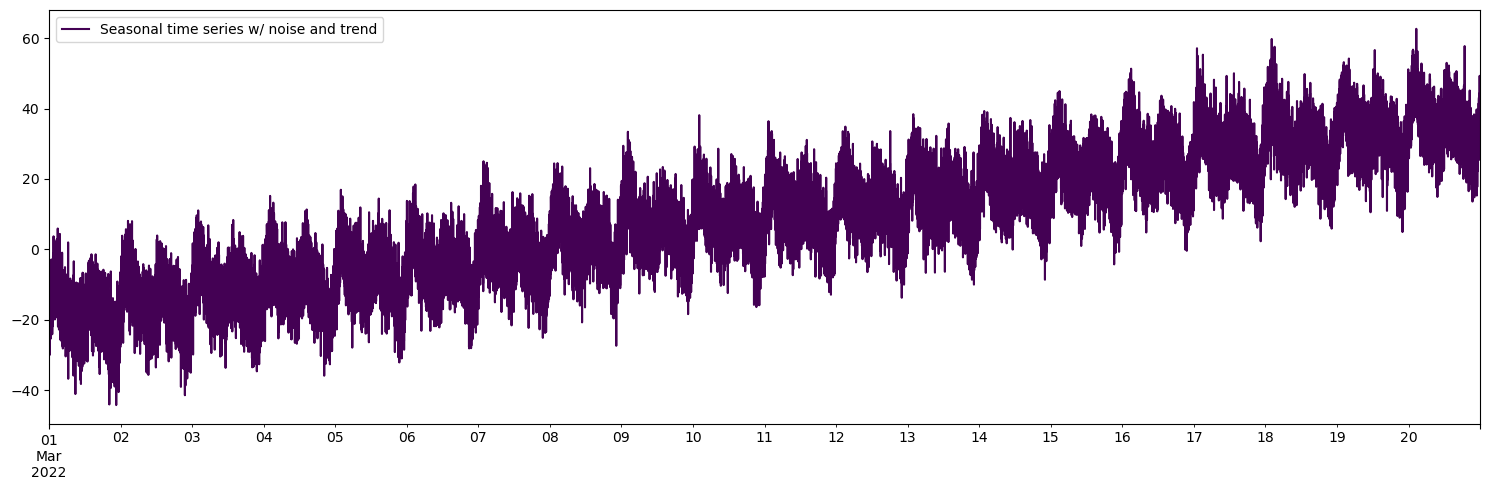

None

In [21]:
#| hide
if show_plots:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

### Data Transformation

__Handle Missing Values, Resample and Normalize__

> In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied.
> 
> This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

#### Training data

##### Build dataframe

In [22]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

##### Build training artifact

In [23]:
df.shape

(28800, 1)

In [24]:
df_training.shape

(28800, 1)

In [25]:
print(config.resampling_freq)

15T


In [26]:
#| export
training_artifact = TSArtifact.from_df(
    df_training, 
    name                    = config.artifact_name, 
    missing_values_technique= config.missing_values_technique,
    resampling_freq         = config.resampling_freq, 
    normalize               = config.normalize_training, 
    path                    = str(Path.home()/config.wandb_artifacts_path),
    verbose                 = 2
)
if verbose > 0: display(training_artifact.metadata)

[ From df ] sd 2022-03-01 00:00:00, ed 2022-03-20 23:59:00
[ From df ] df_query~(28800, 1)
[ From df ] df_missing~(28800, 1)
[ From df ] df_resampled~(1920, 1)
About to write df to  /home/macu/data/wandb_artifacts/-8843217172523872463


{'TS': {'sd': '2022-03-01 00:00:00',
  'ed': '2022-03-20 23:59:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 1920,
  'freq': '<15 * Minutes>',
  'vars': ['Seasonal time series w/ noise and trend'],
  'hash': '-8843217172523872463'}}

In [27]:
#| export
#Debugging 
if df_training.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Testing data

##### Build dataframe & artifact

In [28]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


#### Training + Testing data

##### Build dataframe & artifact

In [29]:
#| export
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(
        df_train_test,
        name=config.artifact_name, 
        missing_values_technique=config.missing_values_technique,
        resampling_freq=config.resampling_freq, 
        normalize=False,
        path=str(Path.home()/config.wandb_artifacts_path)
    )
    if df_train_test.index.duplicated().any():
        print("There exist duplicated value(s) within the dataframe index.")
    else:
        if verbose > 0: print("There is no duplicated value in the dtaframe index")
    if verbose > 0: display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

> 
Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two
> 
> <span style="color:red"> TODO: Modify config.ipynb so it gets wandb config from base.yml </span>.

In [30]:
#| export
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 01_dataset_artifact


In [31]:
#| export
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [32]:
#| export
run.finish()

In [33]:
#| export
from dvats.imports import beep
print("Execution ended")
beep(1)

Execution ended


In [34]:
#| hide
if reset_kernel:
    import os
    os._exit(00)

In [35]:
df_training.head()

,Seasonal time series w/ noise and trend
2022-03-01 00:00:00,-16.037771
2022-03-01 00:01:00,-16.488671
2022-03-01 00:02:00,-18.429100
2022-03-01 00:03:00,-16.876006
2022-03-01 00:04:00,-21.418883
